# XGBoost Modeling

In this Notebook XGBoost can be used to make some magic!
Because each of the model needs to be safed properly. Please specify a name for the model, which describes briefly its specialities:

In [1]:
model_name: str= "Non_Recursive_XGBoost_Model"

# 1. Setting up Colab

Here we set up colab. U knooow it :D 

In case u don't use colab, please specify the variable ```use_colab``` to false. In case u don't use it its unavoidable to make sure that noone changed something online while u change it offline. The results of this would be worse than a division by zero.  

In [2]:
use_colab: bool = True

In case u accidentally run the following code twice u will get following weird and confusing error:

```
OSError: [Errno 107] Transport endpoint is not connected
```

In this case just restart the runtime above. 


In [3]:
if use_colab:
  import os
  from google.colab import drive 
  drive.mount("/content/gdrive", force_remount=True)
  # Change directory for nicer imports
  %cd "/content/gdrive/My Drive/Data_Mining_Cup/05 Code/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Data_Mining_Cup/05 Code


# 2. Notes and Ideas

## Ideas for new Features
Please specify assignment in bold and brackets behind. If nobody is assigned put the "To Be Assigned (TBA)" Flague.
*

## Notes

Currently no notes :( 

# 3. Setting up Notebook

Here we setup some parameters for the notebook to work in the expected ways.

If we want to **use the final test phase** for the later submission, we need to specify the following parameter **```make_final_submission``` to true.** Otherwise the selfmade test set will be used.

In [16]:
make_final_submission: bool = False

In case we don't want to make a final submission, we now have to specify the test_set. In case you change it, please leave a comment on why and what the new one is. If the end is defined as None we use all the data from start_period (inclusive) till the end of dataset. 

In case make_final_submission is True we do not use those parameters.

In [17]:
# This will set the start of test period to 2 weeks before end of data
test_period_start: str="2018-06-02"
# Use till the end
test_period_end: str="2018-06-15"

In [18]:
# These datapoints are for the final submision
final_submission_start: str="2018-06-30"
final_submission_end: str="2018-07-13"

#### Imports

Here you can add imports u need. Please use alphabetical order to not import new stuff twice.

In [5]:
from datetime import date, datetime, timedelta
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from itertools import product
import numpy as np
from math import sqrt 
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from typing import List, Union, Tuple

import xgboost as xgb 
from xgboost import plot_importance 

%matplotlib inline

In case of a "Model not found" Error concerning the Hyperopt package. Please uncomment and run the following line

In [ ]:
# !pip install hyperopt

## Loading data

Here we now load the dataframes by the preceeding notebooks.
Please do not import single datasets and merge them here cause it will end in fatal inconsistencies.

For comfort the following row will define a ```small_data``` attribute. is this True, only a part will be used for training, if False all the data points will be used in the following code.

It will leave the testing and validation data in the same size, only will decrease the data for training.


In [10]:
small_data: bool = True

In case small data should be used, the following line defines the start of this. 

In [11]:
small_data_start_date: str = '20180301'

For the training of XGBoost, we need to specify a validation set. Herefore we no can set the traning_end. Between this and the start of testing will be used as validation set. 


In [12]:
training_end: str = '20180519'

### Label

The last thing which need to be specified is, which label should be used for the training, so what do u want to be predicted. Sadly because of xg boos we only can use exactly one label :( 

In [13]:
labels: List[str] = ["order"]

Therefore this assert. Remove it if we change to another model

In [14]:
assert len(labels) == 1

## Features to delete for training

Turns out another parameter needs to be set. Which feature do we have in the data and should be deleted for training. The date will be deleted seperately

In [ ]:
# added later with all the lag features 
# columns_to_delete: List[str] = []

# 4. Preparation
Here the data is finally fetched

In [19]:
# OPEN PANDAS DATAFRAMES FROM PREPROCESSING 2
try:
  if make_final_submission:
    dynamic_features = pd.read_pickle('./data/dynamic_features_final_nb2.pk')
    static_features = pd.read_pickle('./data/static_features_final_nb2.pk')
  else:
    # dynamic_features = pd.read_pickle('./data/dynamic_features_nb2.pk')
    dynamic_features = pd.read_pickle('./data/dynamic_features_nb2.pk_no_one_and_ws3')
    # static_features = pd.read_pickle('./data/static_features_nb2.pk')
    static_features = pd.read_pickle('./data/static_features_nb2.pk_no_one_and_ws3')
    labels_for_test = pd.read_pickle('./data/orders_for_test.pkl')
except FileNotFoundError as e:
  print(f"One File could not be found. Please rerun the first Notebook, {e}")

In [20]:
for i in range(dynamic_features.shape[1]):
  col_name = dynamic_features.columns[i]
  if dynamic_features[col_name].dtype == "uint8":
    dynamic_features[col_name] = dynamic_features[col_name].astype(int) 

In [21]:
static_features['recommendedRetailPrice_bucket'] = static_features['recommendedRetailPrice_bucket'].astype(int)

Combine the two datasets together

In [22]:
data = dynamic_features.join(static_features.drop('avg_salesPrice_nonunique', axis=1), on="itemID")
data = data.reset_index()

Here we make the dataframe a bit smaller:

In [23]:
if small_data: 
  data = data[data['date'] > small_data_start_date]

In [24]:
columns_to_delete = []

for i in range(data.shape[1]):
  if "order_t-" in data.columns[i]:
    columns_to_delete.append(data.columns[i])

#### Deletion of unused feature


In [25]:
try:
  # do the deletion
  data = data.drop(columns_to_delete, axis=1)
except KeyError as e:
  print(f"I could not delete the columns {e} cause they were not there. \n But hey, they are gone, like intented :D")

#### Adding the label

After this step, data does not exist, only X, y left

In [26]:
# We need to put date also into y to make the split
y = data[['date', *labels]].copy()
X = data.drop(labels, axis=1).copy()

#### Split into train/val/test

Here we create tuples for the respective datapoints.
(X,y) 
In the end we will have train, val and test according to the variables defined above

In [27]:
def split(X, y, training_end, testing_start, testing_end, split_feature='date', labels_for_test=None, delete_split_feature=True):
  
  # Training
  print(f"CREATING TRAINING from [begin, {training_end}]")
  train_X = X[X[split_feature] <= training_end]
  train_y = y[y[split_feature] <= training_end]

  # Validation
  print(f"CREATING VALIDATION from ]{training_end}, {testing_start}[")
  val_X = X[(X[split_feature] > training_end)]
  val_X = val_X[(val_X[split_feature] < testing_start)]
  val_y = y[(y[split_feature]> training_end)]
  val_y = val_y[(val_y[split_feature] < testing_start)]

  assert len(val_X)>0, "val_X must be greater 0"
  assert len(val_y)>0, "val_y must be greater 0"

   # Testing
  print(f"CREATING TESTING from ({testing_start}, end]")
  test_X = X[X[split_feature] >= testing_start & X[split_feature] <= testing_end]
  test_y = y[y[split_feature] >= testing_start & y[split_feature] <= testing_end]
    
  assert len(test_X)>0, "test_X must be greater 0"
  assert len(test_y)>0, "test_y must be greater 0"
    
  if delete_split_feature:
    train_X = train_X.drop([split_feature,'itemID'], axis=1)
    train_y = train_y.drop(split_feature, axis=1)
    val_X = val_X.drop([split_feature,'itemID'], axis=1)
    val_y = val_y.drop(split_feature, axis=1)
    test_X = test_X.drop(split_feature, axis=1)
    test_y = test_y.drop(split_feature, axis=1)
    
  if labels_for_test is not None:
    test_y['order'] = labels_for_test.reset_index()['order'].values
  return (train_X, train_y), (val_X, val_y), (test_X, test_y)

test_start = final_submission_start if make_final_submission else test_period_start
test_end =  final_submission_end if make_final_submission else test_period_end
print(test_end)
train, val, test = split(X,y, training_end, test_start, test_end, labels_for_test=labels_for_test)
del X
del y
#del data

CREATING TRAINING from [begin, 20180519]
CREATING VALIDATION from ]20180519, 2018-06-02[
CREATING TESTING from (2018-06-02, end]


In [30]:
test[0]['prediction'] = test[1]

In [33]:
test[0][test[0]['itemID'] == 1]

,itemID,salesPrice,promoted,avg_daily_salesPrice,avg_daily_salesPrice_nonunique,salesPrice_over_recommended,salesPrice_over_avg_salesPrice,salesPrice_over_avg_salesPrice_nonunique,day_of_year,day_of_month,month,week_nr,promotion_lag1,promotion_lag2,two_days_after_promo,total_sales,count_promotions,de_holidays,days_since_last_promotion,last_promoted_sales,salesPrice_bucket__1,salesPrice_bucket__2,salesPrice_bucket__3,salesPrice_bucket__4,salesPrice_bucket__5,salesPrice_bucket__6,salesPrice_bucket__7,salesPrice_bucket__8,salesPrice_bucket__9,day_of_week__1,day_of_week__2,day_of_week__3,day_of_week__4,day_of_week__5,day_of_week__6,customerRating,recommendedRetailPrice,avg_salesPrice,has_rating,bought_together_cluster,num_promotions,promotion_in_data,avg_sold_promoted,avg_sold_not_promoted,brand,manufacturer,category1,category2,category3,recommendedRetailPrice_bucket,SUM(orders.order),SUM(orders.salesPrice),STD(orders.order),STD(orders.salesPrice),MAX(orders.order),MAX(orders.salesPrice),SKEW(orders.order),SKEW(orders.salesPrice),MIN(orders.order),MIN(orders.salesPrice),MEAN(orders.order),MEAN(orders.salesPrice),COUNT(orders),NUM_UNIQUE(orders.DAY(time)),NUM_UNIQUE(orders.DAY(date)),NUM_UNIQUE(orders.MONTH(time)),NUM_UNIQUE(orders.MONTH(date)),NUM_UNIQUE(orders.WEEKDAY(time)),NUM_UNIQUE(orders.WEEKDAY(date)),MODE(orders.DAY(time)),MODE(orders.DAY(date)),MODE(orders.MONTH(time)),MODE(orders.MONTH(date)),MODE(orders.WEEKDAY(time)),MODE(orders.WEEKDAY(date)),prediction
1590376,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,153,2,6,22,0,0,0,0.0,154.0,0,9.0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.38,8.84,3.11,1,-1,4.0,1,164.5,0.216216,0,1,1,1,1,0,690.0,1788.25,0.483166,0.0,4.0,3.11,2.603882,0.0,1.0,3.11,1.2,3.11,575.0,20.0,20.0,5.0,5.0,7.0,7.0,29.0,29.0,1.0,1.0,0.0,0.0,0.0
1590377,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,154,3,6,22,0,0,0,0.0,139.0,0,10.0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.38,8.84,3.11,1,-1,4.0,1,164.5,0.216216,0,1,1,1,1,0,690.0,1788.25,0.483166,0.0,4.0,3.11,2.603882,0.0,1.0,3.11,1.2,3.11,575.0,20.0,20.0,5.0,5.0,7.0,7.0,29.0,29.0,1.0,1.0,0.0,0.0,0.0
1590378,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,155,4,6,23,0,0,0,0.0,110.0,0,11.0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.38,8.84,3.11,1,-1,4.0,1,164.5,0.216216,0,1,1,1,1,0,690.0,1788.25,0.483166,0.0,4.0,3.11,2.603882,0.0,1.0,3.11,1.2,3.11,575.0,20.0,20.0,5.0,5.0,7.0,7.0,29.0,29.0,1.0,1.0,0.0,0.0,0.0
1590379,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,156,5,6,23,0,0,0,0.0,141.0,0,12.0,30.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4.38,8.84,3.11,1,-1,4.0,1,164.5,0.216216,0,1,1,1,1,0,690.0,1788.25,0.483166,0.0,4.0,3.11,2.603882,0.0,1.0,3.11,1.2,3.11,575.0,20.0,20.0,5.0,5.0,7.0,7.0,29.0,29.0,1.0,1.0,0.0,0.0,0.0
1590380,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,157,6,6,23,0,0,0,0.0,147.0,0,13.0,30.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.38,8.84,3.11,1,-1,4.0,1,164.5,0.216216,0,1,1,1,1,0,690.0,1788.25,0.483166,0.0,4.0,3.11,2.603882,0.0,1.0,3.11,1.2,3.11,575.0,20.0,20.0,5.0,5.0,7.0,7.0,29.0,29.0,1.0,1.0,0.0,0.0,0.0
1590381,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,158,7,6,23,0,0,0,0.0,159.0,0,14.0,30.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.38,8.84,3.11,1,-1,4.0,1,164.5,0.216216,0,1,1,1,1,0,690.0,1788.25,0.483166,0.0,4.0,3.11,2.603882,0.0,1.0,3.11,1.2,3.11,575.0,20.0,20.0,5.0,5.0,7.0,7.0,29.0,29.0,1.0,1.0,0.0,0.0,0.0
1590382,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,159,8,6,23,0,0,0,0.0,141.0,0,15.0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4.38,8.84,3.11,1,-1,4.0,1,164.5,0.216216,0,1,1,1,1,0,690.0,1788.25,0.483166,0.0,4.0,3.11,2.603882,0.0,1.0,3.11,1.2,3.11,575.0,20.0,20.0,5.0,5.0,7.0,7.0,29.0,29.0,1.0,1.0,0.0,0.0,0.0
1590383,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,160,9,6,23,0,0,0,0.0,136.0,0,16.0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4.38,8.84,3.11,1,-1,4.0,1,164.5,0.216216,0,1,1,1,1,0,690.0,1788.25,0.483166,0.0,4.0,3.11,2.603882,0.0,1.0,3.11,1.2,3.11,575.0,20.0,20.0,5.0,5.0,7.0,7.0,29.0,29.0,1.0,1.0,0.0,0.0,0.0
1590384,1,8.260357,0,3.11,3.11,0.35181,1.0,1.0,161,10,6,23,0,0,0,0.0,138.0,0,17.0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4.38,8.84,3.1

### Save Test, train and val data

Here we safe the preprocessing data.

First the Test data:

In [ ]:
# with open(f"./data/{model_name}_test.pk","wb") as f:
#     pickle.dump(test, f)
#     f.close()

Then the training data

In [ ]:
# with open(f"./data/{model_name}_train.pk","wb") as f:
#     pickle.dump(train, f)
#     f.close()

At last the validation data

In [ ]:
# with open(f"./data/{model_name}_val.pk","wb") as f:
#     pickle.dump(val, f)
#     f.close()

# The Model

### Load the data
Here we load the data from above step. __Why?__ This is to make sure that also one of the three main parts of the notebook can be run by themself :) In case all of the notebook is run, this part can be ignored. 

In [ ]:
# with open(f"./data/{model_name}_train.pk","rb") as f:
#     train = pickle.load(f)
#     f.close()

# with open(f"./data/{model_name}_test.pk","rb") as f:
#     test = pickle.load(f)
#     f.close()
    
# with open(f"./data/{model_name}_val.pk","rb") as f:
#     val = pickle.load(f)
#     f.close()   

## The Custom Evaluation and Objective Function

Here is space to create several custom evaluation and objective functions to later use in XGBoost.

In [ ]:
use_constant_price = False

def monetary_value_objective(predt: np.ndarray, dtrain: Union[xgb.DMatrix, np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
  """
  Loss is the difference to the optimal value (how much more would we get, if we 
  predicted correctly). Minimal loss 0 is reached when the prediction matches 
  the true value exactly.

  Squared version (for nicer gradients).

  predt = model prediction
  dtrain = labels and sample weights
  Currently, dtrain is a numpy array.
  """
  item_price = 1

  # Use the following if dtrain is in xgb.DMatrix format.
  # y = dtrain.get_label()
  y = dtrain

  mask1 = predt <= y  # Predict too few
  mask2 = predt > y  # Predict too much

  if use_constant_price or train[0]["salesPrice"].shape[0] != predt.shape[0]:
    if not use_constant_price:
      print("`amount` is not None. Using constant item price.")
    item_price = 1
    item_price_1 = 1
    item_price_2 = 1
  else:
    # The following assertion fails if amount not None
    assert train[0]["salesPrice"].shape[0] == predt.shape[0]
    item_price = train[0]["salesPrice"]
    item_price_1 = train[0]["salesPrice"][mask1]
    item_price_2 = train[0]["salesPrice"][mask2]

  grad = item_price**2 * (predt - y)  
  # Gradient is negative if prediction is too low, and positive if it is too high
  # Here scale it (0.72 = 0.6**2 * 2)
  grad[mask1] = 2 * grad[mask1]
  grad[mask2] = 0.72 * grad[mask2]

  hess = np.empty_like(grad)
  hess[mask1] = 2 * item_price_1**2
  hess[mask2] = 0.72 * item_price_2**2

  # For some reason, gradient must be negated, but hessian not
  grad = -grad

  return grad, hess

In [ ]:
def monetary_value_eval(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
  item_price = dtrain.get_weight()
  y = dtrain.get_label()

  predt = np.maximum(predt, 0)  # Remove negative values

  mask1 = predt <= y  # Predict too few
  mask2 = predt > y  # Predict too much
 
  revenue = np.empty_like(predt)
  revenue[mask1] = item_price[mask1] * predt[mask1]
  revenue[mask2] = item_price[mask2] * (1.6 * y[mask2] - 0.6 * predt[mask2])

  total_revenue = revenue.sum()

  return "monetary-value", total_revenue

monetary_value = metrics.make_scorer(monetary_value_eval)

## XGBoost Regressor Model

In case we just need to fast train the model to see if it works we can set this following amount variable. This will set the training data to this amount. Set it to ```None``` if all the data should be used.

In [ ]:
amount: Union[int, None] = None  # 1000

### Hyper parameters tuning 

more parameters can be added here in the parameter space: 
range can also be changed for more fine tuning 

In [ ]:
para_space = {
            'n_estimators': hp.quniform('n_estimators', 10, 20, 1),
            'max_depth': hp.quniform("max_depth", 3, 10, 1),
            'min_child_weight': hp.quniform('min_child_weight', 1, 5, 1),
            'learning_rate':hp.quniform('learning_rate', 0.05, 0.2, 0.05),  
            'gamma': hp.quniform('gamma', 0.8, 1, 0.1),
            'subsample':hp.quniform('subsample', 0.7, 1, 0.1),
            'eval_metric': monetary_value,            
            'tree_method':'auto', # Sadly I need to put this to auto
            'objective': monetary_value_objective,          
            'seed': 7
        }

The following parameter explains how many rounds for hyperparameter tuning should be used:

In [ ]:
evaluation_round: int = 5

### Actual Hyperparameter training
This method returns a evaluation function so it creates a function which creates a model

In [ ]:
def eval_scoring(amount=None):
    amount = amount or len(train[0])
        
    def eval_fc(para_space):
        xgb_model = xgb.XGBRegressor(
                              n_estimators = int(para_space['n_estimators']), 
                              max_depth = int(para_space['max_depth']),
                              min_child_weight=int(para_space['min_child_weight']),
                              learning_rate = para_space['learning_rate'],
                              gamma = para_space['gamma'],
                              subsample = para_space['subsample'],
                              feval = para_space['eval_metric'],
                              tree_method = para_space['tree_method'],
                              objective = para_space['objective'],
                              seed = para_space['seed']
                            )
        sample_weights_train = train[0][:amount].salesPrice.values
        sample_weights_val = val[0][:amount].salesPrice.values
        
        eval_set = [(train[0][:amount],train[1][:amount]), (val[0][:amount], val[1][:amount])]
        eval_set_weights = [sample_weights_train, sample_weights_val]
        
        xgb_model.fit(train[0][:amount], train[1][:amount], eval_set = eval_set,
                      eval_metric = monetary_value_eval, 
                      early_stopping_rounds = 10, verbose = False,
                      sample_weight=sample_weights_train, sample_weight_eval_set=eval_set_weights)

        train_pred = xgb_model.predict(train[0][:amount])
        train_rmse = sqrt(metrics.mean_squared_error(train[1][:amount], train_pred))

        val_pred = xgb_model.predict(val[0][:amount])
        val_rmse = sqrt(metrics.mean_squared_error(val[1][:amount], val_pred))

        # CHANGED FROM HERE
        val_dmatrix = xgb.DMatrix(val[0][:amount], label=val[1][:amount], weight=sample_weights_val)
        _, val_mon = monetary_value_eval(val_pred, val_dmatrix)
        
        print("\n-----------------------------------------------")
        print(f"Train RMSE: {train_rmse} | Val RMSE: {val_rmse} | Val monetary: {val_mon}")
        print(f"Trained with parameters: \n  {para_space}")
        print("--------------------------------------------------\n")
        
        # Return negative monetary value because hyperopt will select the model with the minimal loss
        return {'loss': -val_mon, 'status': STATUS_OK, 'model': xgb_model }

        # CHANGED UNTIL HERE
    return eval_fc

The actual hyperparameter tuning will be done now:

In [ ]:
def hyperpara_tuning(para_space):
    """
    Returns the best set of hyperparamters, 
    given a parameter space and a evaluation function 
    """
    trials = Trials()
    best_model = fmin(fn=eval_scoring(amount=amount),
                      space=para_space,
                      algo=tpe.suggest,
                      max_evals=evaluation_round,
                      trials=trials
                     )
    
    return trials, best_model

In [ ]:
# set runtime environment to GPU at: Runtime -> Change runtime type 
trials, best_hyperparams = hyperpara_tuning(para_space)
final_xgb_model = trials.best_trial['result']['model']
assert final_xgb_model is not None, "Oooops there is no model created :O "

print("\n\n\n############################################\n")
print("THE BEST PARAMETER WHERE:")
print(best_hyperparams)

[15:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

-----------------------------------------------
Train RMSE: 26.337958444643327 | Val RMSE: 27.40631507964089 | Val monetary: -3101805.0
Trained with parameters: 
  {'eval_metric': make_scorer(monetary_value_eval), 'gamma': 0.8, 'learning_rate': 0.1, 'max_depth': 4.0, 'min_child_weight': 2.0, 'n_estimators': 11.0, 'objective': <function monetary_value_objective at 0x7f90f3708598>, 'seed': 7, 'subsample': 0.7000000000000001, 'tree_method': 'auto'}
--------------------------------------------------

[15:43:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

-----------------------------------------------
Train RMSE: 24.985279353407375 | Val RMSE: 26.527147047189814 | Val monetary: -2523876.5
Trained with parameters: 
  {'eval_metric': make_scorer(monetary_value_eval), 'gamma': 1.0, 'learning_rat

### final xgb model based on Grid Search


Here we can train the model again based on the best hyperparameters. But this is only in some times useful and therefore commented out.

In [ ]:
# def best_xgb_model(x_train, y_train, x_val, y_val, best_hyperparams):
#   xgb_model = xgb.XGBRegressor(n_estimators = int(best_hyperparams['n_estimators']), 
#                                learning_rate = best_hyperparams['learning_rate'], 
#                                gamma = best_hyperparams['gamma'],
#                                max_depth = int(best_hyperparams['max_depth']), 
#                                min_child_weight = int(best_hyperparams['min_child_weight']),
#                                subsample = best_hyperparams['subsample'],
#                                tree_metric = 'gpu_hist', 
#                                objective = monetary_value_objective,
#                                feval = monetary_value,
#                                seed = 7)

#   xgb_model.fit(x_train, y_train, verbose = True, eval_metric = monetary_value_eval, #'rmse',
#                   eval_set = [(x_train, y_train), (x_val, y_val)])
    
#   return xgb_model

In [ ]:
# final_xgb_model = best_xgb_model(train[0], train[1], val[0], val[1], best_hyperparams)

### Model Results 
Here we can have a analytic look on the trained model. Was it good ? Did it make sense? Hungry for answers? Then take a look at following crazy lines of code

In [ ]:
train_predictions = final_xgb_model.predict(train[0])
train_predictions = [round(i) for i in train_predictions]
print("Train RMSE : %.8g" % sqrt(metrics.mean_squared_error(train[1], train_predictions)))

val_predictions = final_xgb_model.predict(val[0])
val_predictions = [round(i) for i in val_predictions]
print("Val RMSE : %.8g" % sqrt(metrics.mean_squared_error(val[1], val_predictions)))

Train RMSE : 24.98111
Val RMSE : 26.527102


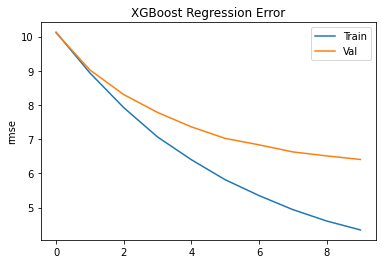

In [ ]:
results = final_xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost Regression Error')
plt.show()

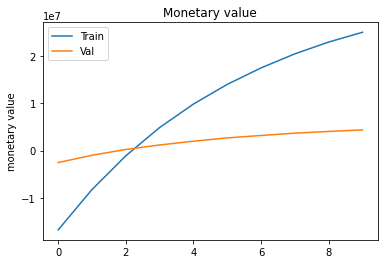

In [ ]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['monetary-value'], label='Train')
ax.plot(x_axis, results['validation_1']['monetary-value'], label='Val')
ax.legend()
plt.ylabel('monetary value')
plt.title('Monetary value')
plt.show()

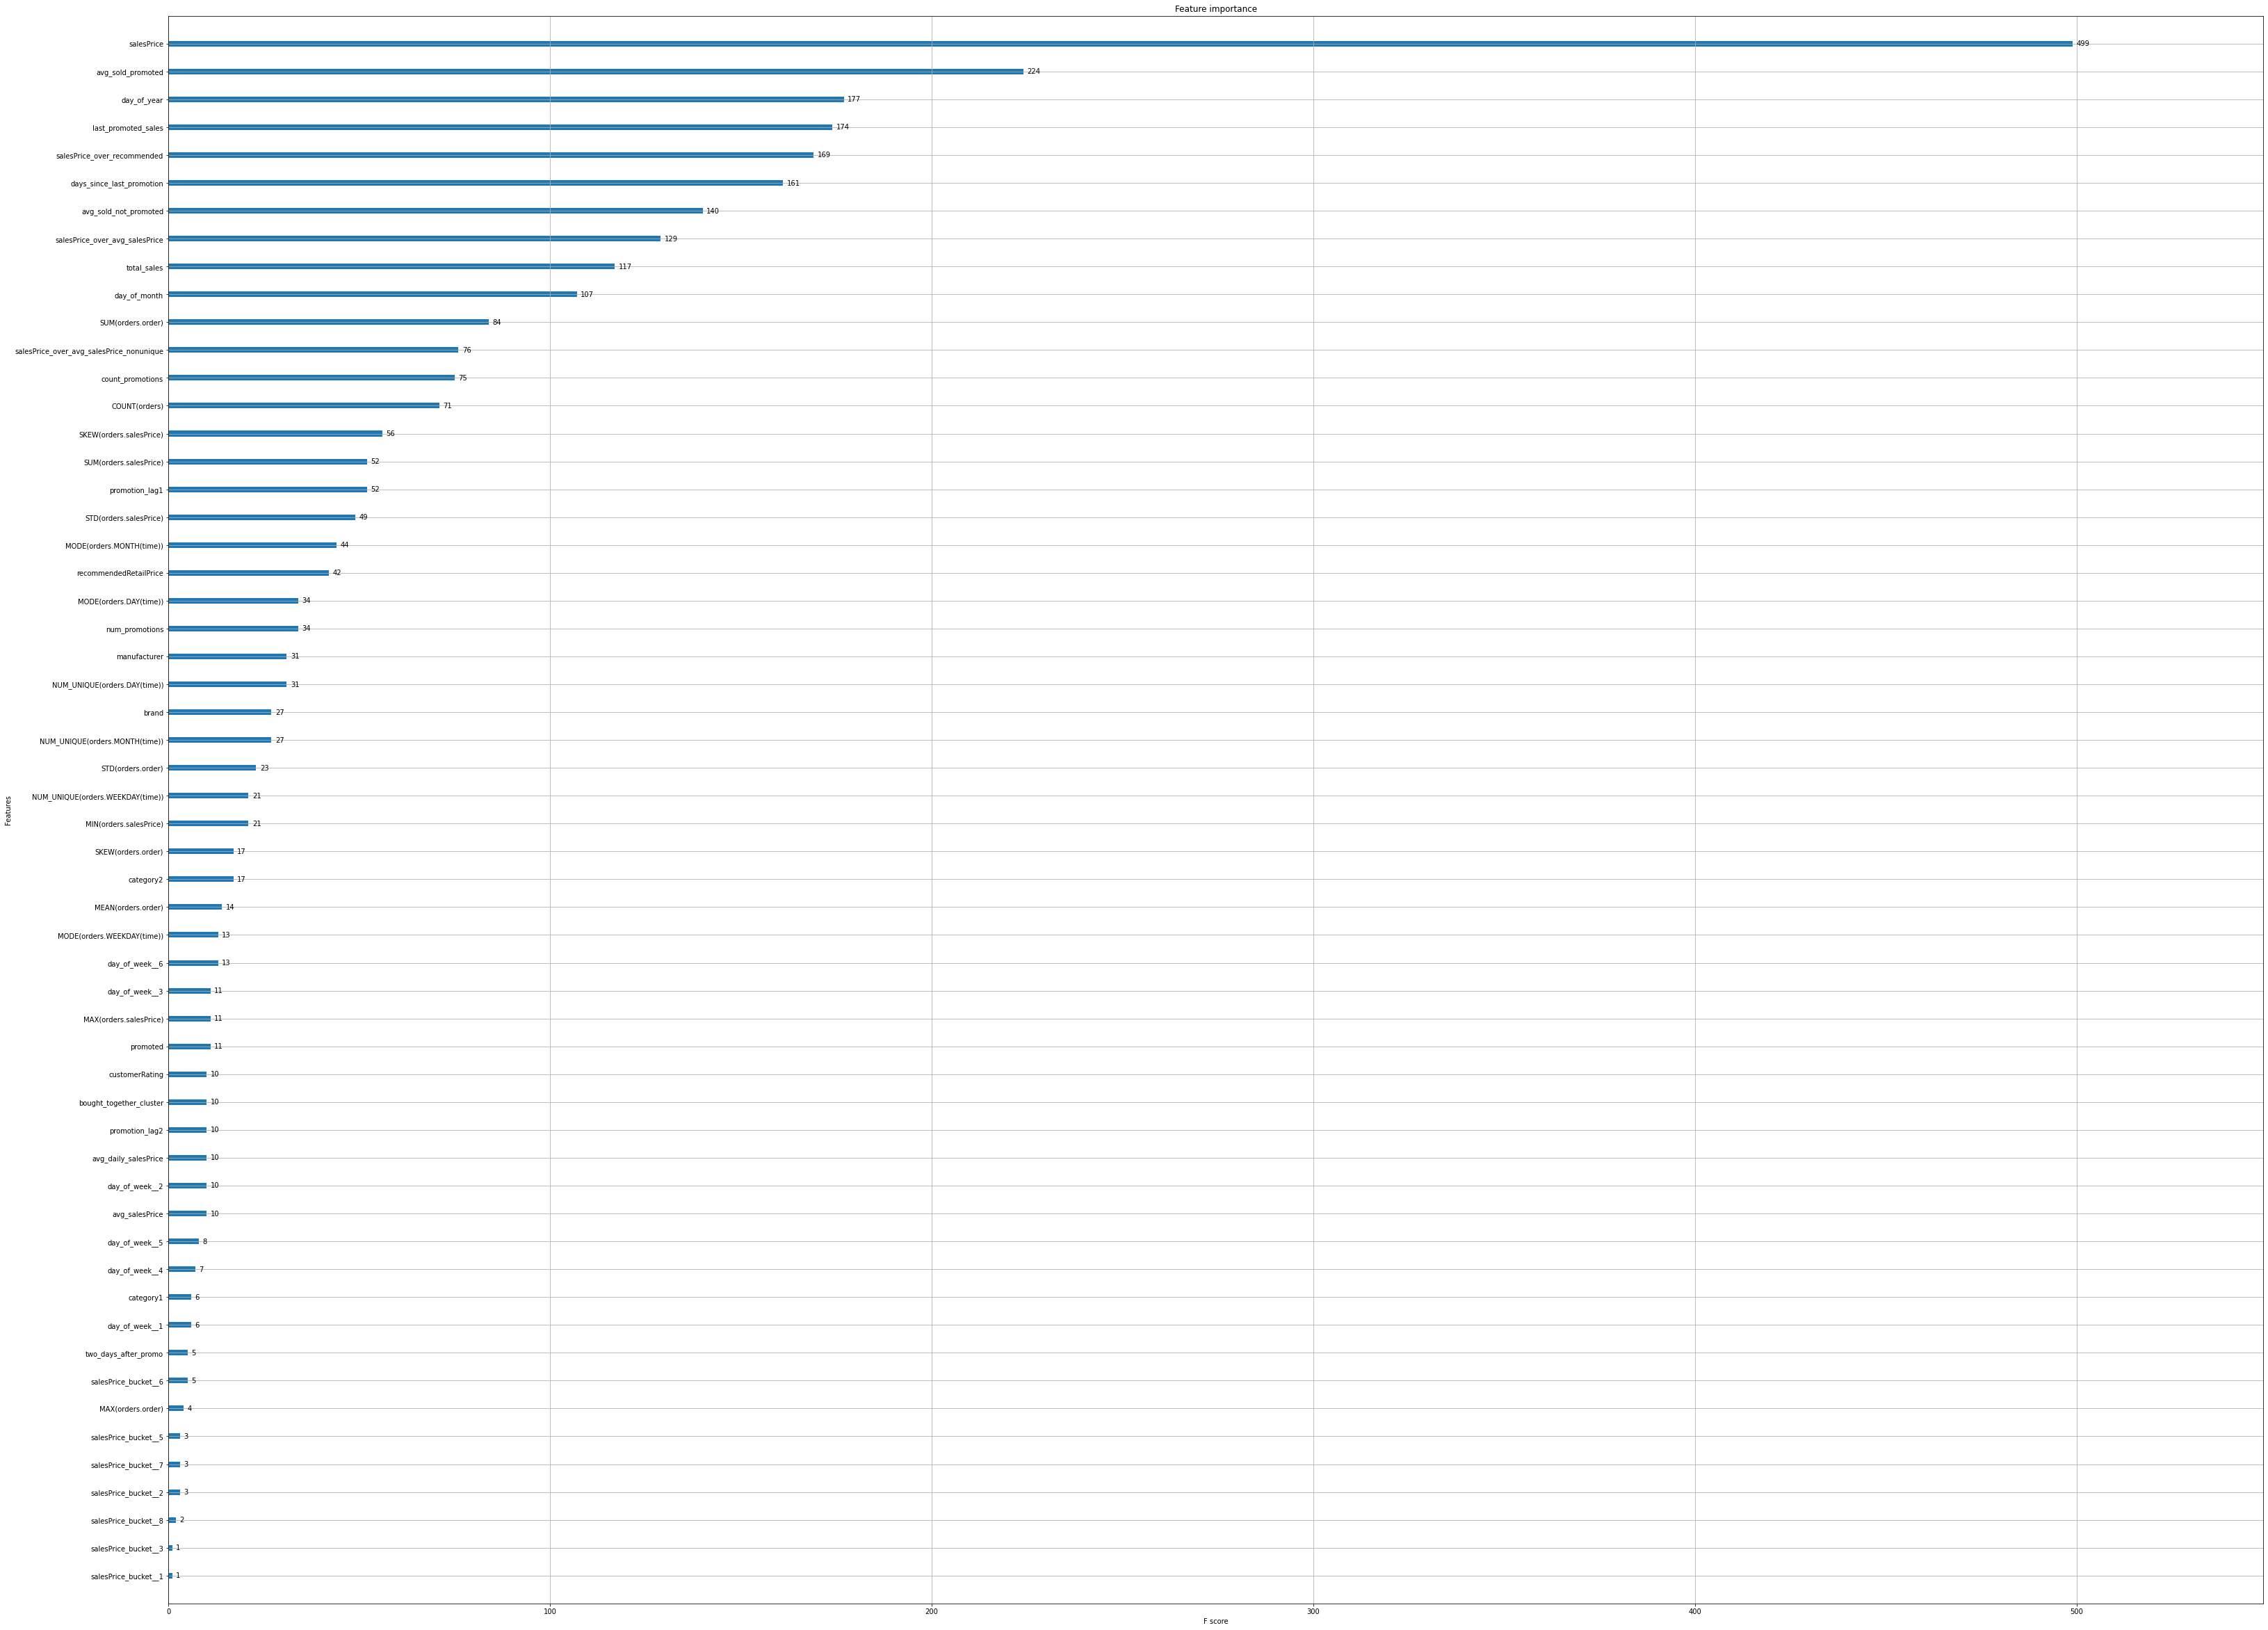

In [ ]:
ax = plot_importance(final_xgb_model)
fig = ax.figure
fig.set_size_inches(54, 42)

### Save the model

Here we now save the model. To distinguish between used models, we can use suffixes. A suffix will then be used to find the right model. If the following variable equals None, simply the current date will be taken as suffix. The final file then is called {modelname}_{suffix}.

In [ ]:
suffix: str= '28062020'

---

In [ ]:
suffix = suffix if suffix else datetime.now().strftime('%m%d%Y')
with open(f"./models/{model_name}_{suffix}.pk","wb") as f:
    pickle.dump(final_xgb_model, f)
    f.close()

# Prediction

This part is used to save the model, and create the predictions already. In case we run the whole notebook, no changes need to be made. 
In case **only this part** should be executed, we need to input the name of the model.  Because we know already the name of the model (see upthere somewhere) we only need the suffix (Most probably the date of training).


In [ ]:
# suffix_for_import = None

### Load Model

In [ ]:
# if final_xgb_model is None:
#     suffix_for_import = suffix_for_import if suffix_for_import else datetime.now().strftime('%m%d%Y')
#     with open(f"./models/{model_name}_{suffix_for_import}.pk","rb") as f:
#         final_xgb_model = pickle.load(f)
#         f.close()
#     print("Loaded model")
# else:
#     print("Use the already created model")

In [ ]:
# with open(f"./data/{model_name}_test.pk","rb") as f:
#     test = pickle.load(f)
#     f.close()

Here we also load the data again

In [ ]:
# with open(f"./data/{model_name}_train.pk","rb") as f:
#     train = pickle.load(f)
#     f.close()

# with open(f"./data/{model_name}_test.pk","rb") as f:
#     test = pickle.load(f)
#     f.close()
    
# with open(f"./data/{model_name}_val.pk","rb") as f:
#     val = pickle.load(f)
#     f.close()   

# labels_for_test = pd.read_pickle('./data/orders_for_test.pkl')

## Non-recursive Prediction


In [ ]:
info = pd.read_csv('/content/gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/infos.csv', delimiter='|', index_col="itemID")

# creating the sample_submission dataframe (with predition, true_demand, and simulationPrice -> to generate total revenue directly in this notebook)

# add prediction 
test_predictions = final_xgb_model.predict(test[0].drop('itemID', axis = 1))
test[0]['demandPrediction'] = pd.Series(test_predictions, index = test[0].index)
test[0]['demandPrediction'] = test[0]['demandPrediction'].round().astype(int) # round first, then sum 
sample_submission = test[0][['itemID','demandPrediction']].groupby('itemID').sum()

# add target 
test[0]['true_demand'] = test[1]
sample_submission['true_demand'] = test[0][['itemID','true_demand']].groupby('itemID').sum()

# add simulation price 
sample_submission['simulationPrice'] = info['simulationPrice']

In [ ]:
test[1]

,order
1590376,0.0
1590377,0.0
1590378,0.0
1590379,0.0
1590380,0.0
...,...
1883335,0.0
1883336,0.0
1883337,0.0
1883338,0.0


In [ ]:
# calculate total revenue:

mask1 = sample_submission['demandPrediction'] <= sample_submission['true_demand']  # Predict too few
mask2 = sample_submission['demandPrediction'] > sample_submission['true_demand']  # Predict too much

revenue = np.empty_like(sample_submission['demandPrediction'])
revenue[mask1] = sample_submission['simulationPrice'][mask1] * sample_submission['demandPrediction'][mask1]
revenue[mask2] = sample_submission['simulationPrice'][mask2] * (1.6 * sample_submission['true_demand'][mask2] - 0.6 * sample_submission['demandPrediction'][mask2])

total_revenue = revenue.sum()

total_revenue

2890206

In [ ]:
sample_submission

,demandPrediction,true_demand,simulationPrice
itemID,,,
1,0,3.0,3.43
2,0,0.0,9.15
3,19,141.0,14.04
4,7,145.0,14.10
5,0,3.0,7.48
...,...,...,...
10459,0,0.0,14.71
10460,0,0.0,325.67
10461,0,0.0,190.53


### Safe the sample submission

In [ ]:
sample_submission['demandPrediction'].to_csv(f'submission_non_recursive_28062020.csv', sep='|')

# testing for errors

In [6]:
orders = pd.read_csv('/content/gdrive/My Drive/Data_Mining_Cup/02 Data/DMC20_Data/orders.csv', delimiter='|', index_col="itemID")


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
orders[(orders['time'] > "2018-06-02") & (orders['time'] < "2018-06-16")].groupby('itemID').sum()

,transactID,order,salesPrice
itemID,,,
3,2258700,1,14.04
5,3969802,2,14.96
6,4954419,4,69.00
10,2266121,1,24.17
12,2283450,1,2.11
...,...,...,...
10441,10589319,6,2071.50
10442,17647965,10,28417.40
10443,12374747,7,841.54
